In [2]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[0])

In [3]:
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

In [4]:
df_list = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list.append(df)

In [5]:
foreigner = df_list[0]
register = df_list[1]

register = register.drop(register.columns[0], axis=1)
foreigner = foreigner.drop(foreigner.columns[0], axis=1)

In [6]:
cat_dict = {10 : '숙박',
20 : '레저용품',
21 : '레저업소',
22 : '문화취미',
30 : '가구',
31 : '전기',
32 : '주방용구',
33 : '연료판매',
34 : '광학제품',
35 : '가전',
40 : '유통업',
42 : '의복',
43 : '직물',
44 : '신변잡화',
50 : '서적문구',
52 : '사무통신',
60 : '자동차판매',
62 : '자동차 정비',
70 : '의료기관',
71 : '보건위생',
80 : '요식업소',
81 : '음료식품',
92 : '수리서비스'}

In [7]:
# foreigner.groupby('COUNTRY_NM')[['USE_CNT','USE_AMT']].sum().reset_index().sort_values(by=['USE_AMT','USE_CNT'], ascending=[0,0])

In [8]:
with open(os.path.join(pickle_file_path,'card_code_to_name_dict.pickle'), 'rb') as f:
    card_code_to_dong_dict = pickle.load(f)

In [9]:
register['region_code'] = register.GU_CD.astype(str)+register.DONG_CD.astype(str)

In [10]:
register['HDONG_NM'] = register.region_code.map(card_code_to_dong_dict.get('행정동명'))

### 객단가 

In [61]:
register.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM
0,20190201,110,517,10,F,25,11,595,110517,동인동
1,20190201,110,517,10,F,50,5,243,110517,동인동
2,20190201,110,517,10,F,55,5,27,110517,동인동
3,20190201,110,517,10,M,20,11,243,110517,동인동
4,20190201,110,517,10,M,25,11,433,110517,동인동


In [62]:
register.drop(['DONG_CD','GU_CD','region_code'], axis=1, inplace=True)

#### 성별별 객단가 

In [63]:
tmp_df = register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        get_group(('소공동','M')).\
        iloc[:,3:]

In [64]:
tmp_df.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=7).mean().fillna(method='bfill').mean()

17.55063825931306

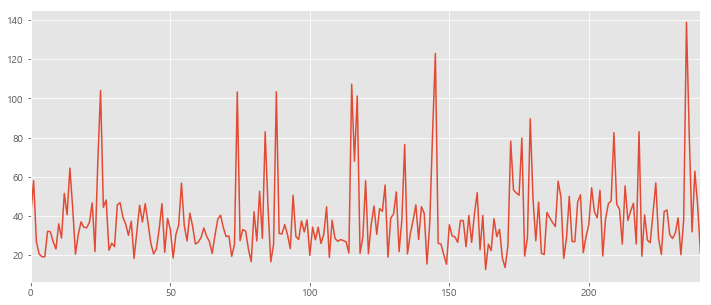

In [29]:
tmp_df.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.plot(figsize=(12,5))

In [94]:
register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup').\
        pivot_table(index='SEX_CD',columns='HDONG_NM',values='mean_daily_gup')

HDONG_NM,고산1동,고산2동,고산3동,공릉1동,공릉2동,광희동,남산1동,남산2동,남산3동,남산4동,...,지산2동,청구동,파동,필동,하계1동,하계2동,황금1동,황금2동,황학동,회현동
SEX_CD,,,,,,,,,,,,,,,,,,,,,
F,23.223873,29.779541,21.313296,21.725311,16.254400,28.345256,26.917874,33.335718,17.852205,30.692376,...,24.921699,17.737125,24.709514,13.534662,24.825368,12.679215,18.374014,56.065683,30.069290,50.219769
M,22.645632,31.523312,21.190795,21.867278,17.526868,27.162539,30.258360,35.122461,25.111804,26.202475,...,23.468563,16.452198,26.829940,14.411895,22.947493,11.105243,16.933946,47.002573,29.474147,39.765151


In [96]:
GUP_by_SEX_CD = register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup')

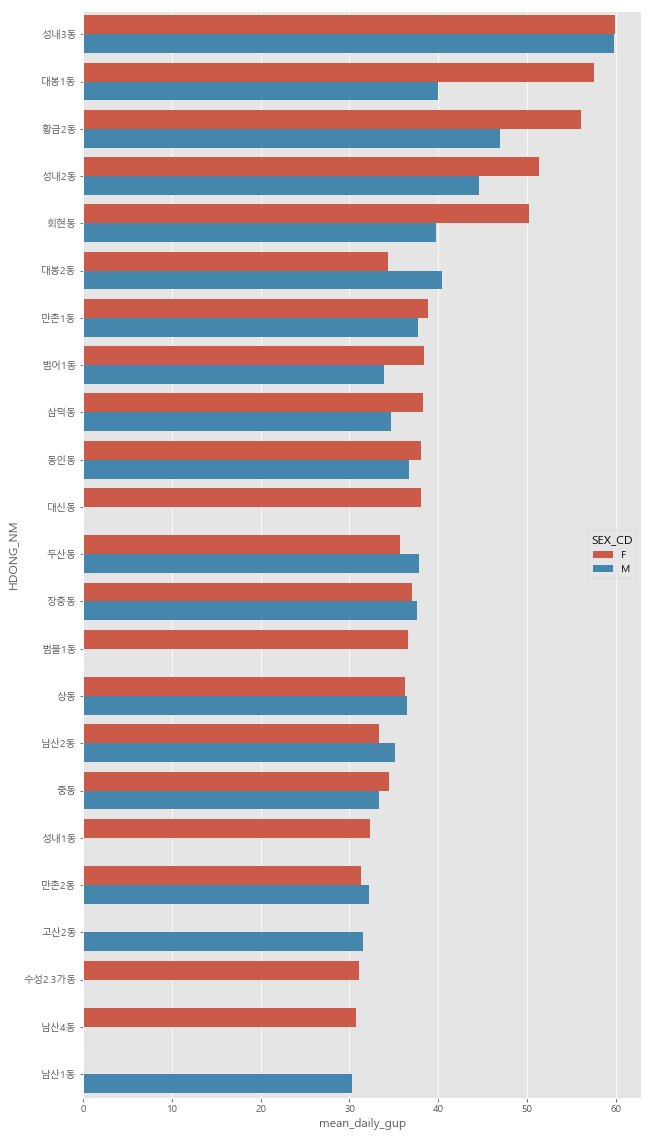

In [109]:
plt.figure(figsize=(10,20))
sns.barplot(
    data = GUP_by_SEX_CD.sort_values(by='mean_daily_gup', ascending=False).head(39),
    y = 'HDONG_NM',
    x = 'mean_daily_gup',
    hue = 'SEX_CD'
)
# plt.xticks(rotation=90)

##### 성별 + 카테고리별 객단가

In [56]:
def f(df):
    if (df.shape[0]!=2):
        return 1
    else:
        return df.iloc[0,-1]/df.iloc[1,-1]

In [151]:
register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        groupby(['HDONG_NM','MCT_CAT_CD']).\
        get_group(('소공동',20))

,HDONG_NM,SEX_CD,MCT_CAT_CD,mean_cat_gup
1614,소공동,F,20,115.370914
1635,소공동,M,20,141.977024


In [144]:
# F/M 
SEX_CAT_rate_GUP = register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        groupby(['HDONG_NM','MCT_CAT_CD']).\
        apply(f).\
        reset_index(name='rate')

In [163]:
SEX_CAT_rate_GUP['MCT_CAT_NM'] = SEX_CAT_rate_GUP.MCT_CAT_CD.map(cat_dict)

In [164]:
# SEX_CAT_rate_GUP.drop('MCT_CAT_CD', axis=1, inplace=True)

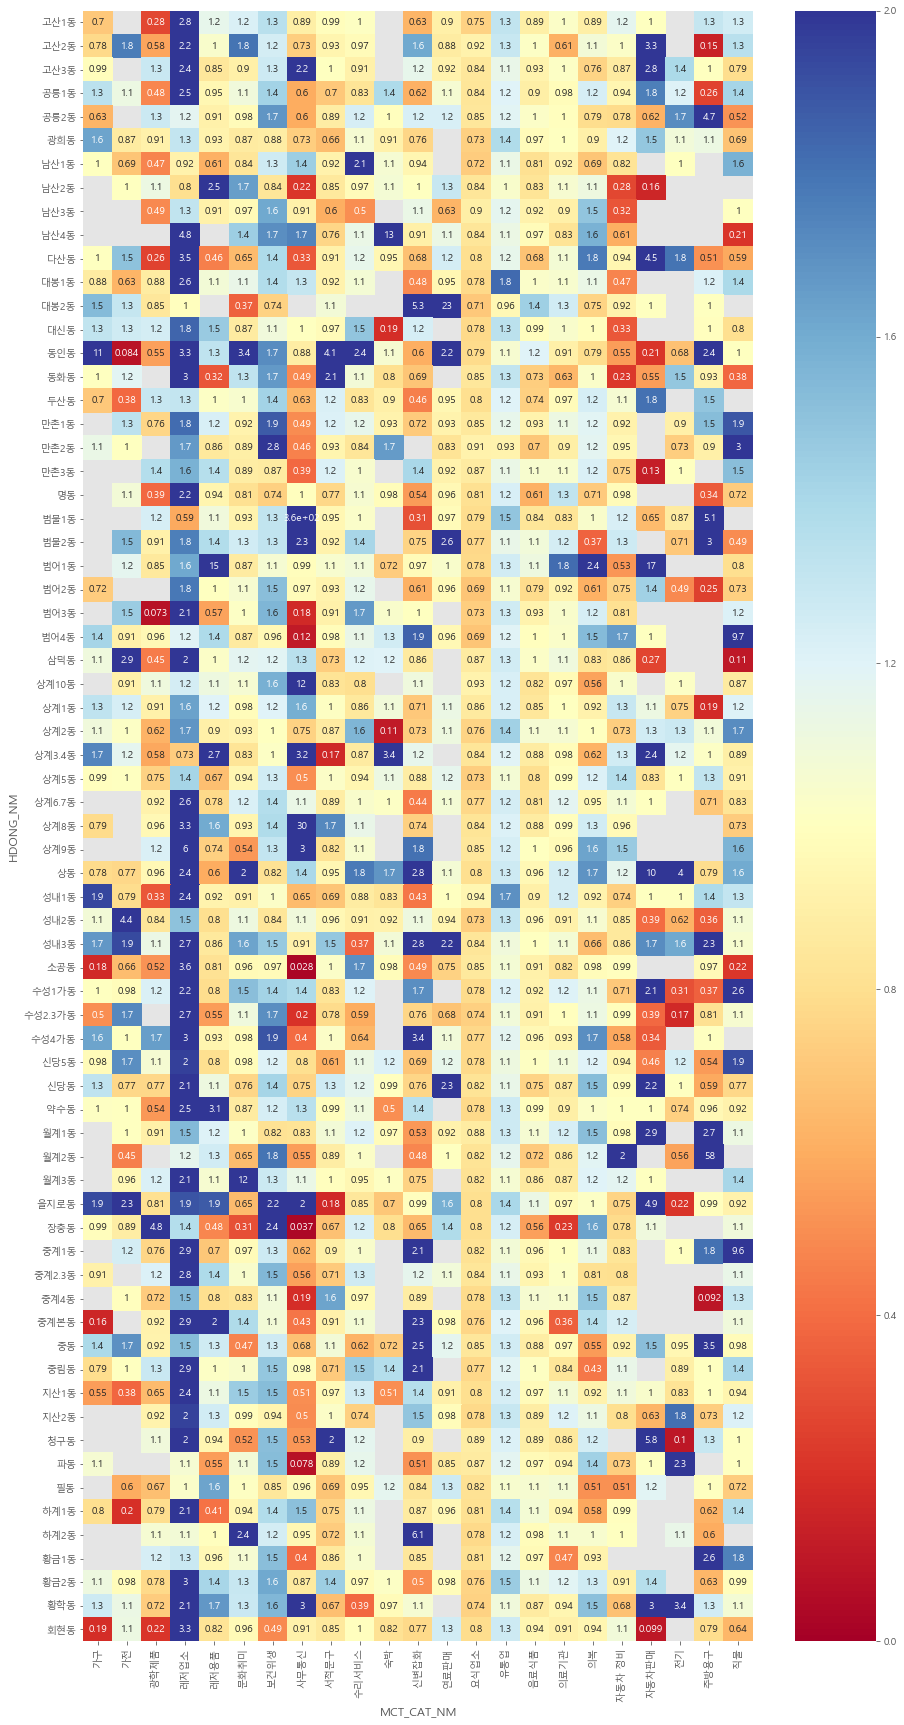

In [186]:
plt.figure(figsize=(15,30))
sns.heatmap(
    SEX_CAT_rate_GUP.pivot('HDONG_NM','MCT_CAT_NM','rate'), cmap='RdYlBu', vmin=0, vmax=2, annot=True
)

* 레저업소에서 여성의 객단가가 남성의 객단가에 비해 매우 높은것으로 파악됨  
 => 악기의 소비가 여성이 더 많다고 판단할 수 있다면 이해할 수 있는 객단가비율 수치로 생각
* 요식업소의 경우 남성의 객단가가 여성의 객단가에 비해 높은것으로 보임. (남성과 여성의 먹는 양에 대한 차이도 어느정도 포함 될 수도?)
* 유통업의 경우는 여성의 객단가가 남성의 객단가에 비해 조금 높은편
* 보건위생의 경우 역시 여성의 객단가가 남성의 객단가에 비해 조금 높은편
* 주방용품의 경우 여성이 높은경우, 남성이 높은경우 고루 분포하고 비율들이 극단적인 편

In [168]:
tmp_df = register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup')

#### 연령대별 객단가 

In [11]:
tmp_df = register.groupby(['HDONG_NM','AGE_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','AGE_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup')

In [14]:
from mpl_toolkits.mplot3d import Axes3D

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
le = LabelEncoder()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68]), <a list of 69 Text xticklabel objects>)

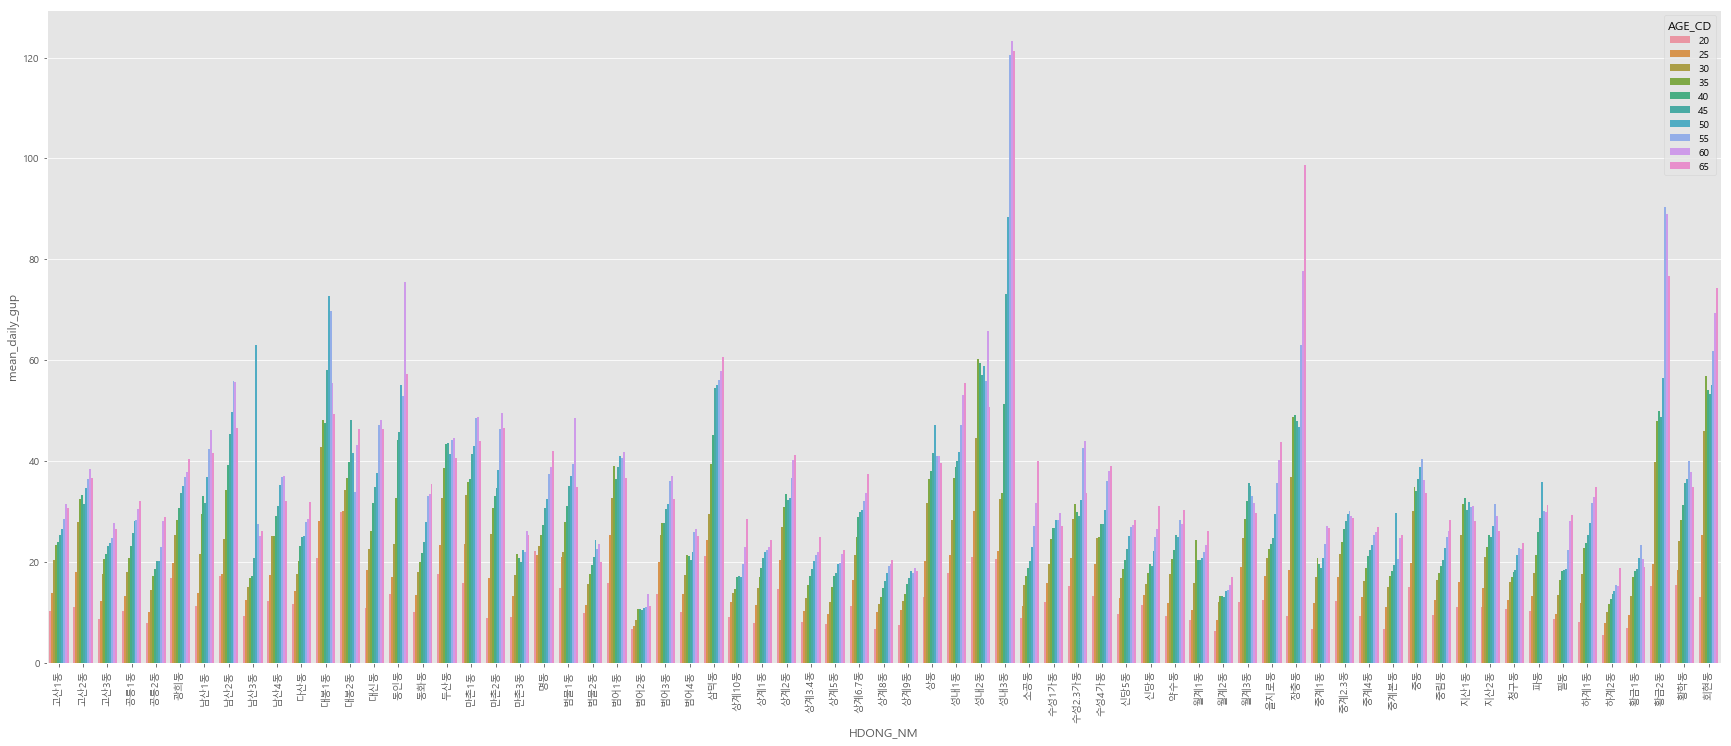

In [42]:
plt.figure(figsize=(30,12))
sns.barplot(
    data = tmp_df,
    x = 'HDONG_NM',
    y = 'mean_daily_gup',
    hue = 'AGE_CD'
)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

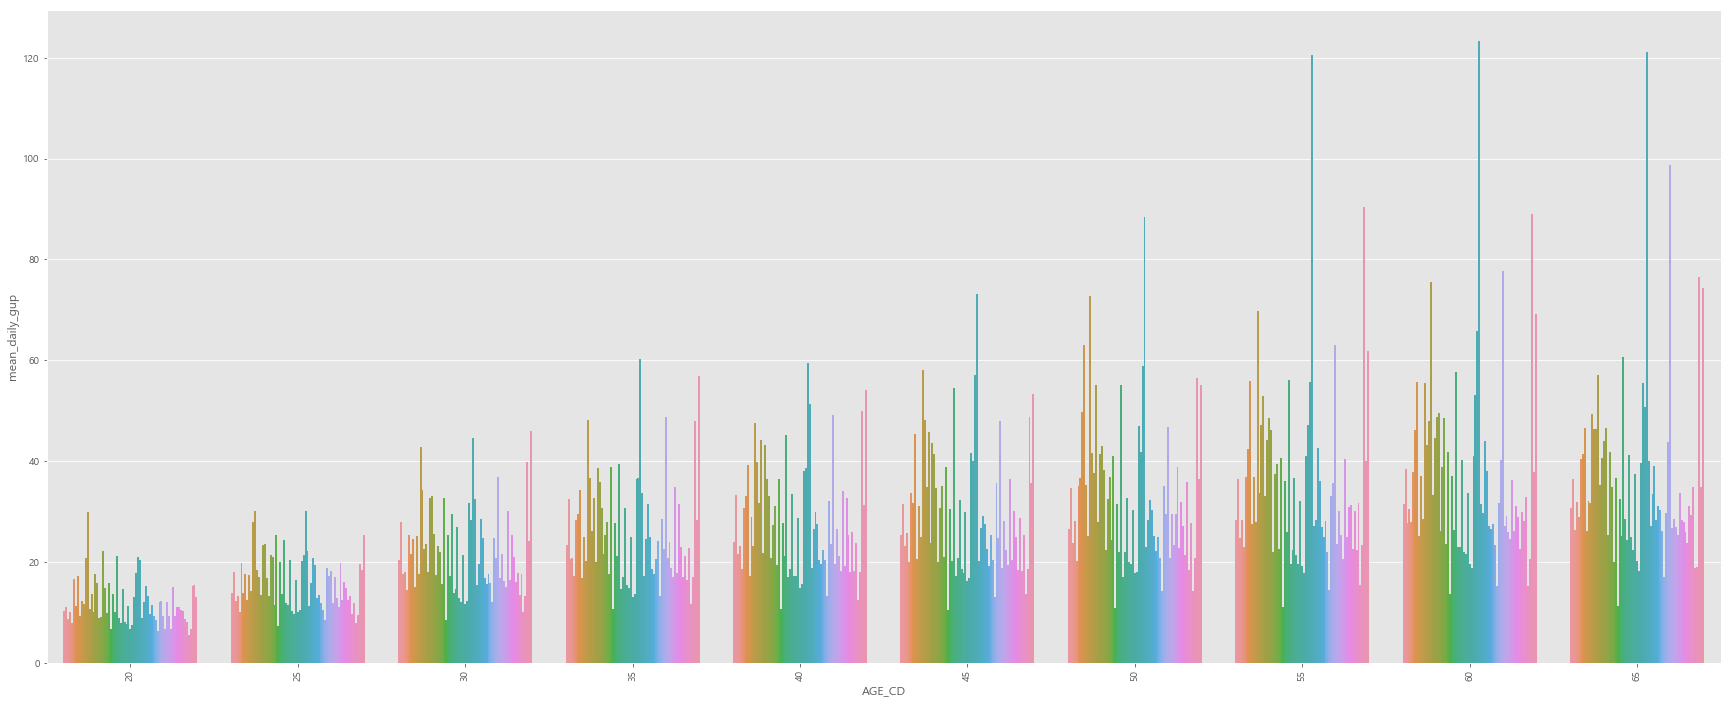

In [52]:
plt.figure(figsize=(30,12))
sns.barplot(
    data = tmp_df,
    x = 'AGE_CD',
    y = 'mean_daily_gup',
    hue = 'HDONG_NM',
)
plt.legend().set_visible(False)
plt.xticks(rotation=90)

* 고연령대(55세 이상)의 객단가가 높게 나옴

#####  연령대 + 카테고리별 객단가

In [85]:
tmp = register.groupby(['HDONG_NM','AGE_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','AGE_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        pivot_table(index=['HDONG_NM','AGE_CD'], columns='MCT_CAT_CD', values='mean_cat_gup')

In [90]:
cat_dict

{10: '숙박',
 20: '레저용품',
 21: '레저업소',
 22: '문화취미',
 30: '가구',
 31: '전기',
 32: '주방용구',
 33: '연료판매',
 34: '광학제품',
 35: '가전',
 40: '유통업',
 42: '의복',
 43: '직물',
 44: '신변잡화',
 50: '서적문구',
 52: '사무통신',
 60: '자동차판매',
 62: '자동차 정비',
 70: '의료기관',
 71: '보건위생',
 80: '요식업소',
 81: '음료식품',
 92: '수리서비스'}

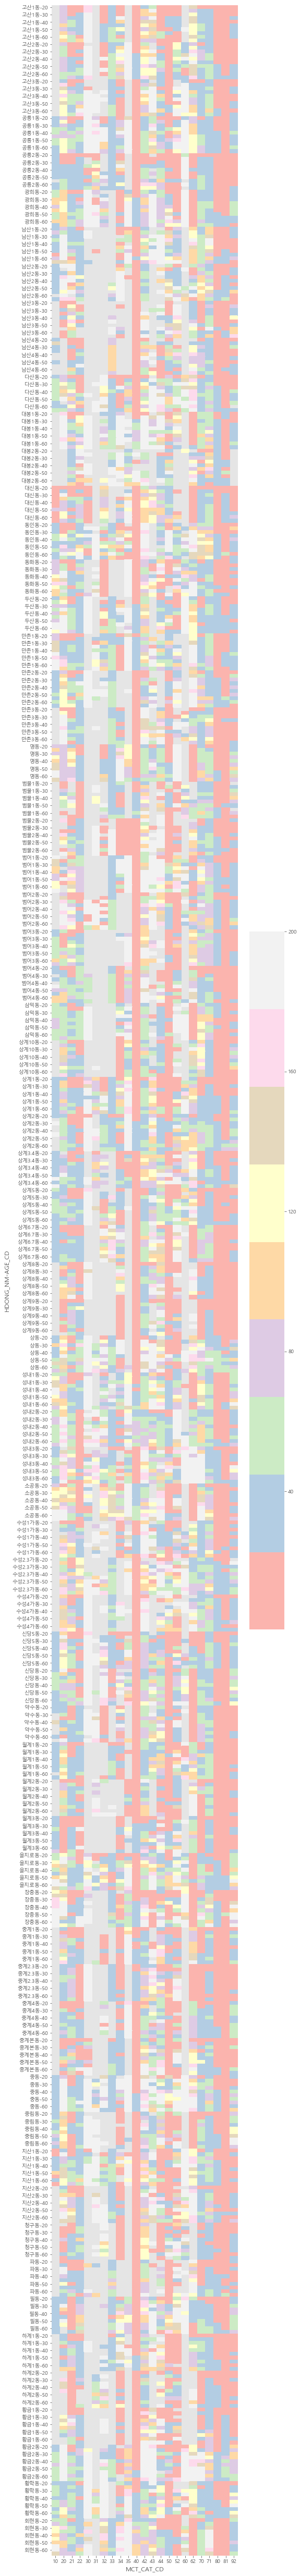

In [95]:
plt.figure(figsize=(8,90))
sns.heatmap(tmp, cmap='Pastel1', vmax=200)

In [74]:
def f2(df):
    return (df.mean_cat_gup / df.mean_cat_gup.cumsum().values[-1]).values

#### 성별,연령대 전체 객단가 

In [97]:
register.groupby(['HDONG_NM','STD_DD'])[['USE_CNT','USE_AMT']].sum().reset_index()

,HDONG_NM,STD_DD,USE_CNT,USE_AMT
0,고산1동,20190201,15384,411993
1,고산1동,20190202,17809,450567
2,고산1동,20190203,16580,391901
3,고산1동,20190204,15604,361414
4,고산1동,20190205,8247,143570
...,...,...,...,...
16624,회현동,20200527,75773,2913451
16625,회현동,20200528,74521,2880475
16626,회현동,20200529,80701,3435369
16627,회현동,20200530,66647,3803298


In [106]:
cat_dict

{10: '숙박',
 20: '레저용품',
 21: '레저업소',
 22: '문화취미',
 30: '가구',
 31: '전기',
 32: '주방용구',
 33: '연료판매',
 34: '광학제품',
 35: '가전',
 40: '유통업',
 42: '의복',
 43: '직물',
 44: '신변잡화',
 50: '서적문구',
 52: '사무통신',
 60: '자동차판매',
 62: '자동차 정비',
 70: '의료기관',
 71: '보건위생',
 80: '요식업소',
 81: '음료식품',
 92: '수리서비스'}

In [11]:
register['MCT_CAT_NM'] = register['MCT_CAT_CD'].map(cat_dict)

In [12]:
register.eval('mean_AMT = USE_AMT/USE_CNT').groupby('MCT_CAT_NM')['mean_AMT'].quantile([.1,.5,.75,.9,.95,.99,.995]).reset_index().pivot('MCT_CAT_NM','level_1','mean_AMT')

level_1,0.100,0.500,0.750,0.900,0.950,0.990,0.995
MCT_CAT_NM,,,,,,,
가구,10.800000,206.875000,564.944444,1267.980000,1895.907500,3679.665000,4604.848000
가전,12.400000,73.200000,242.400000,826.520000,1359.900000,3114.720000,4089.104000
광학제품,6.555556,16.500000,31.000000,142.520000,328.200000,1195.642000,1814.912500
레저업소,3.090909,11.500000,30.400000,86.777778,173.200000,569.200000,805.504000
레저용품,9.000000,53.000000,96.200000,183.981481,276.000000,734.536667,1152.890000
문화취미,4.888889,15.600000,31.800000,62.085315,94.293750,304.753000,530.466566
보건위생,9.000000,25.200000,50.181818,98.928571,156.400000,408.965887,594.216667
사무통신,3.666667,9.166667,22.800000,109.200000,330.542857,936.000000,1531.500000
서적문구,3.218750,12.833333,22.600000,42.000000,70.404444,315.775875,595.200000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

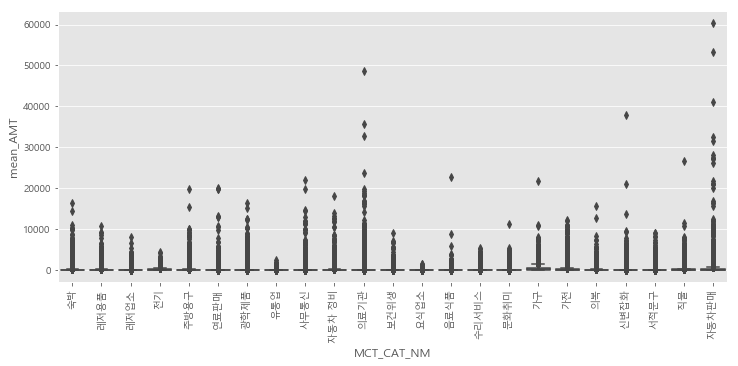

In [13]:
plt.figure(figsize=(12,5))
sns.boxplot(
    data = register.eval('mean_AMT = USE_AMT/USE_CNT'),
    x = 'MCT_CAT_NM',
    y = 'mean_AMT'
)

plt.xticks(rotation=90)

카드데이터 이상치제거 할 수 있는방법 있나??

In [22]:
register

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,mean_AMT
0,20190201,110,517,10,F,25,11,595,110517,동인동,숙박,54.090909
1,20190201,110,517,10,F,50,5,243,110517,동인동,숙박,48.600000
2,20190201,110,517,10,F,55,5,27,110517,동인동,숙박,5.400000
3,20190201,110,517,10,M,20,11,243,110517,동인동,숙박,22.090909
4,20190201,110,517,10,M,25,11,433,110517,동인동,숙박,39.363636
...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,20200531,350,720,81,M,45,19,127,350720,상계10동,음료식품,6.684211
2537749,20200531,350,720,81,M,50,33,211,350720,상계10동,음료식품,6.393939
2537750,20200531,350,720,81,M,55,9,61,350720,상계10동,음료식품,6.777778
2537751,20200531,350,720,81,M,60,19,194,350720,상계10동,음료식품,10.210526


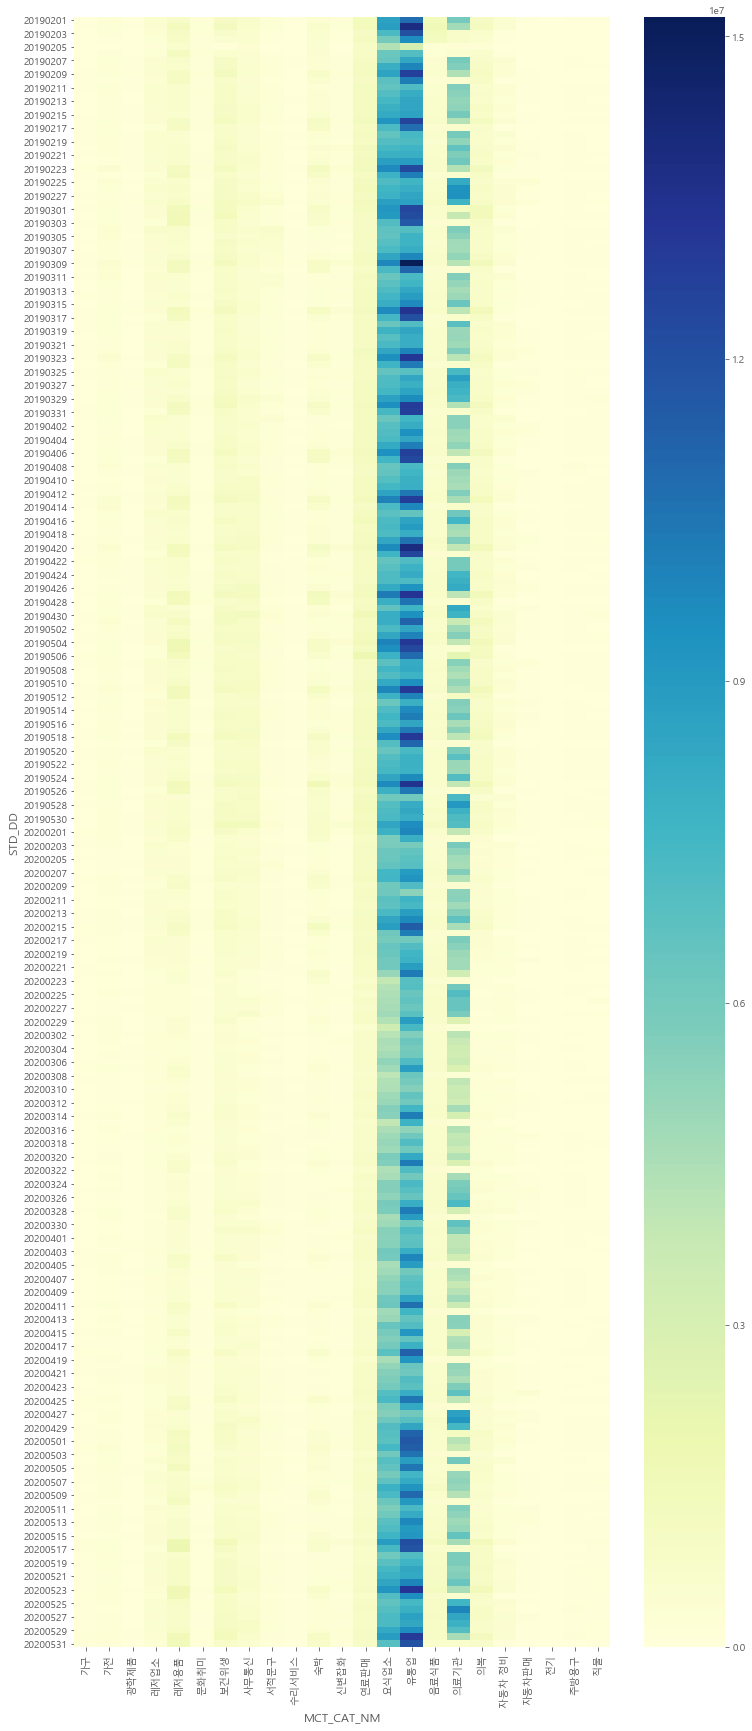

In [26]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.groupby(['MCT_CAT_NM', 'STD_DD']).USE_AMT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','USE_AMT' ).fillna(0),
cmap = 'YlGnBu', vmax= )

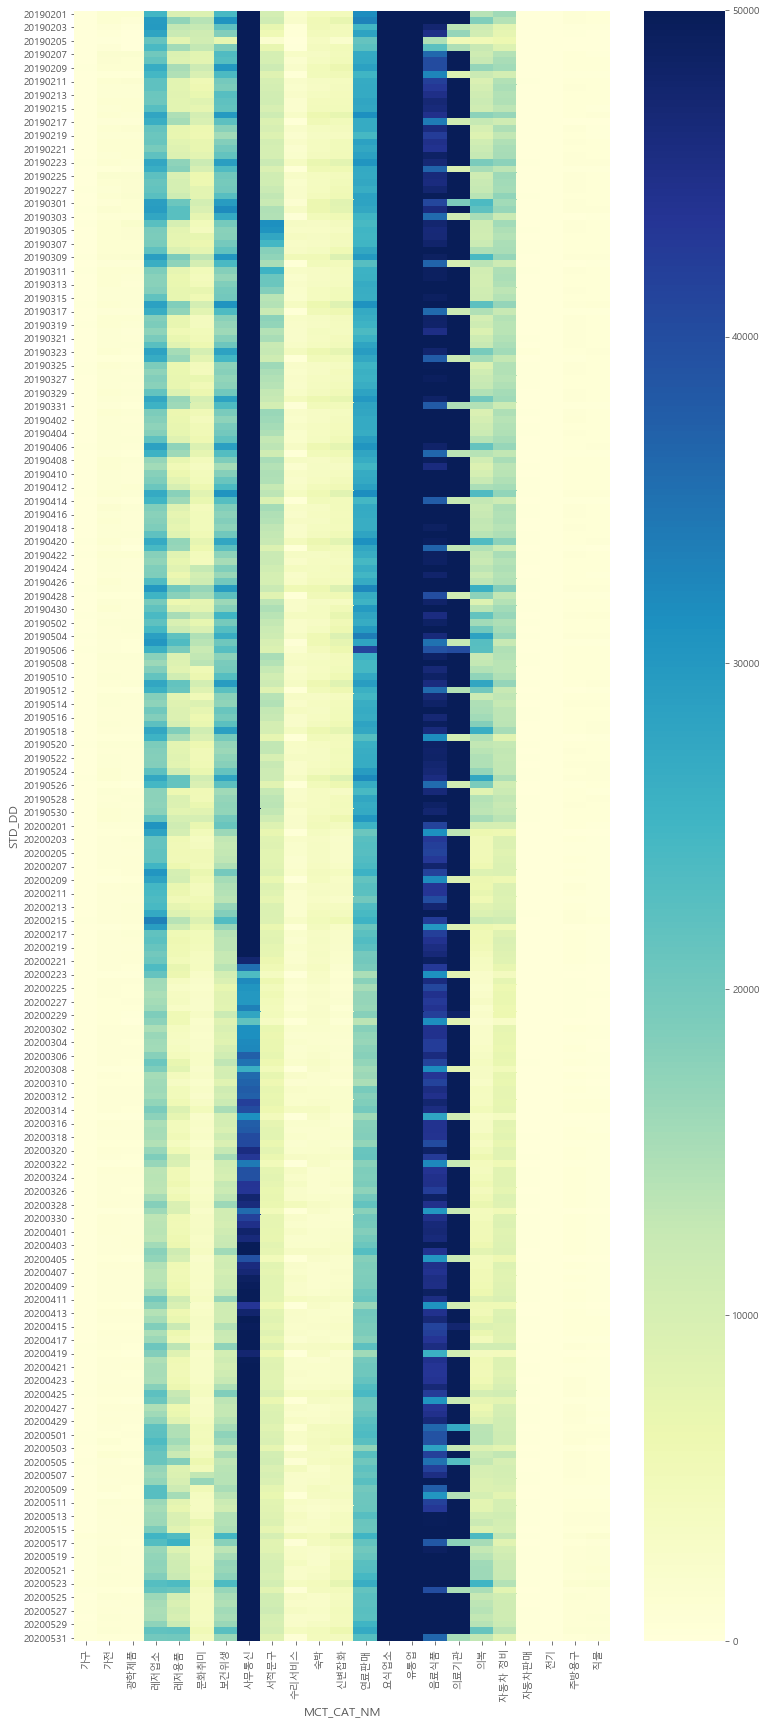

In [27]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.groupby(['MCT_CAT_NM', 'STD_DD']).USE_CNT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','USE_CNT' ).fillna(0),
cmap = 'YlGnBu', vmax=50000)

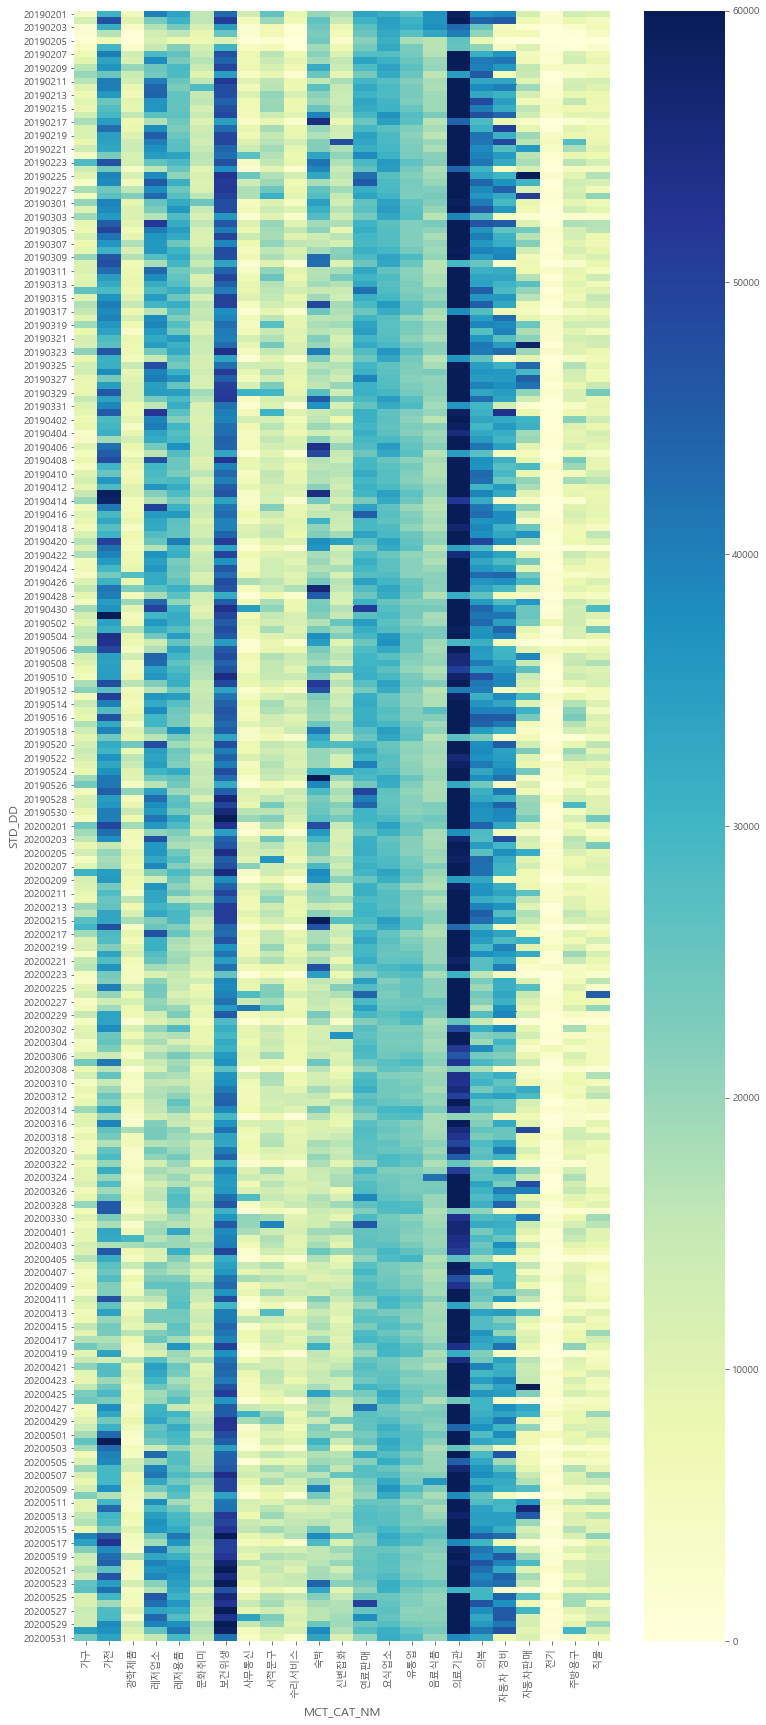

In [21]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.eval('mean_AMT = USE_AMT/USE_CNT').groupby(['MCT_CAT_NM', 'STD_DD']).mean_AMT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','mean_AMT' ).fillna(0),
cmap = 'YlGnBu', vmax=60000)

In [30]:
register.eval('mean_AMT=USE_AMT/USE_CNT').groupby

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,mean_AMT
0,20190201,110,517,10,F,25,11,595,110517,동인동,숙박,54.090909
1,20190201,110,517,10,F,50,5,243,110517,동인동,숙박,48.600000
2,20190201,110,517,10,F,55,5,27,110517,동인동,숙박,5.400000
3,20190201,110,517,10,M,20,11,243,110517,동인동,숙박,22.090909
4,20190201,110,517,10,M,25,11,433,110517,동인동,숙박,39.363636
...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,20200531,350,720,81,M,45,19,127,350720,상계10동,음료식품,6.684211
2537749,20200531,350,720,81,M,50,33,211,350720,상계10동,음료식품,6.393939
2537750,20200531,350,720,81,M,55,9,61,350720,상계10동,음료식품,6.777778
2537751,20200531,350,720,81,M,60,19,194,350720,상계10동,음료식품,10.210526
